In [1]:
!pip install yfinance statsmodels pmdarima matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import itertools
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.4 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed


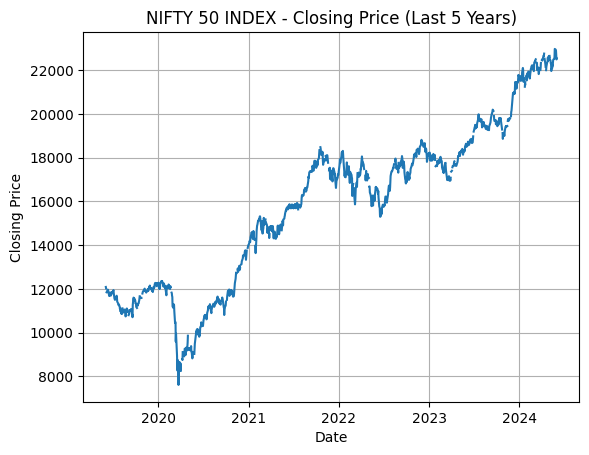

In [2]:
data = yf.download("^NSEI", start="2019-06-01", end="2024-06-01")['Close']
data.dropna(inplace=True)
data = data.asfreq('B')  # Setting business day frequency
plt.plot(data)
plt.title("NIFTY 50 INDEX - Closing Price (Last 5 Years)")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.grid()
plt.show()

In [3]:
result = adfuller(data.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])
if result[1] < 0.05:
    print("=> Data is stationary.")
else:
    print("=> Data is non-stationary.")


ADF Statistic: -0.08804606278372838
p-value: 0.9506162518696102
Critical Values: {'1%': np.float64(-3.4356950607889254), '5%': np.float64(-2.863900342696613), '10%': np.float64(-2.568026681232353)}
=> Data is non-stationary.


In [4]:
d = 0
diff_data = data.copy()
while True:
    result = adfuller(diff_data.dropna())
    if result[1] < 0.05:
        break
    diff_data = diff_data.diff().dropna()
    d += 1

print(f"\nMade data stationary by differencing {d} time(s)")


Made data stationary by differencing 1 time(s)


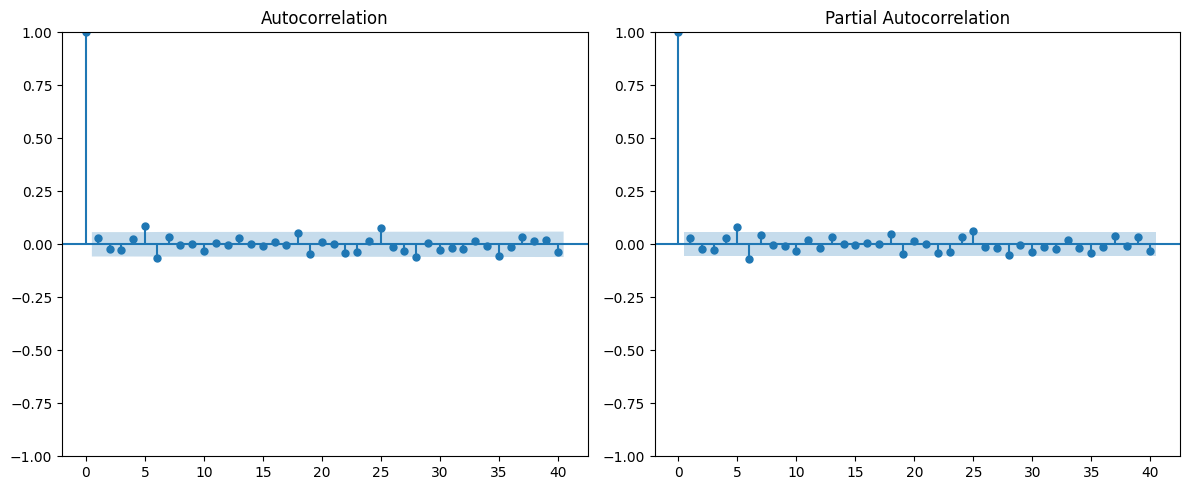

In [5]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(diff_data, ax=plt.gca(), lags=40)
plt.subplot(1, 2, 2)
plot_pacf(diff_data, ax=plt.gca(), lags=40)
plt.tight_layout()
plt.show()

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Defining p, d, q range
p = d = q = range(0, 4)
pdq = list(itertools.product(p, d, q))

best_aic = np.inf
best_order = None
split = int(len(data) * 0.95) #testing on data of roughly 3 months
train, test = data[:split], data[split:]
print("Trying combinations:")
for order in pdq:
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        print(f"ARIMA{order} AIC: {model_fit.aic}")
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
    except:
        continue

print("\nBest ARIMA order:", best_order)


Trying combinations:
ARIMA(0, 0, 0) AIC: 29557.691701703556
ARIMA(0, 0, 1) AIC: 21054.652978374477
ARIMA(0, 0, 2) AIC: 19844.8399169125
ARIMA(0, 0, 3) AIC: 18939.208013847732
ARIMA(0, 1, 0) AIC: 15204.199067585036
ARIMA(0, 1, 1) AIC: 15206.179376537322
ARIMA(0, 1, 2) AIC: 15207.967161357545
ARIMA(0, 1, 3) AIC: 15209.934304392034
ARIMA(0, 2, 0) AIC: 16028.164979599607
ARIMA(0, 2, 1) AIC: 15199.572093400526
ARIMA(0, 2, 2) AIC: 15201.563277300902
ARIMA(0, 2, 3) AIC: 15203.16068431706
ARIMA(0, 3, 0) AIC: 17375.083688992276
ARIMA(0, 3, 1) AIC: 16060.197291817622
ARIMA(0, 3, 2) AIC: 15245.239312609438
ARIMA(0, 3, 3) AIC: 15251.781168879836
ARIMA(1, 0, 0) AIC: 15227.676120515716
ARIMA(1, 0, 1) AIC: 15231.327806275962
ARIMA(1, 0, 2) AIC: 15233.100489295433
ARIMA(1, 0, 3) AIC: 15235.525336498591
ARIMA(1, 1, 0) AIC: 15206.17995747706
ARIMA(1, 1, 1) AIC: 15201.108291020333
ARIMA(1, 1, 2) AIC: 15209.929558428648
ARIMA(1, 1, 3) AIC: 15204.95191515417
ARIMA(1, 2, 0) AIC: 15696.626247947976
ARIMA(1, 

In [7]:
model = ARIMA(train, order = best_order)
model_fit = model.fit()
print(model_fit.summary())

arima_forecast = model_fit.forecast(steps=len(test))
arima_fitted_values = model_fit.fittedvalues
arima_forecast.index = test.index


                               SARIMAX Results                                
Dep. Variable:                  ^NSEI   No. Observations:                 1239
Model:                 ARIMA(2, 2, 3)   Log Likelihood               -7589.496
Date:                Sat, 28 Jun 2025   AIC                          15190.993
Time:                        18:03:17   BIC                          15221.716
Sample:                    06-03-2019   HQIC                         15202.548
                         - 02-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9025      0.007   -267.368      0.000      -1.916      -1.889
ar.L2         -0.9790      0.007   -134.631      0.000      -0.993      -0.965
ma.L1          0.9282      0.061     15.170      0.0

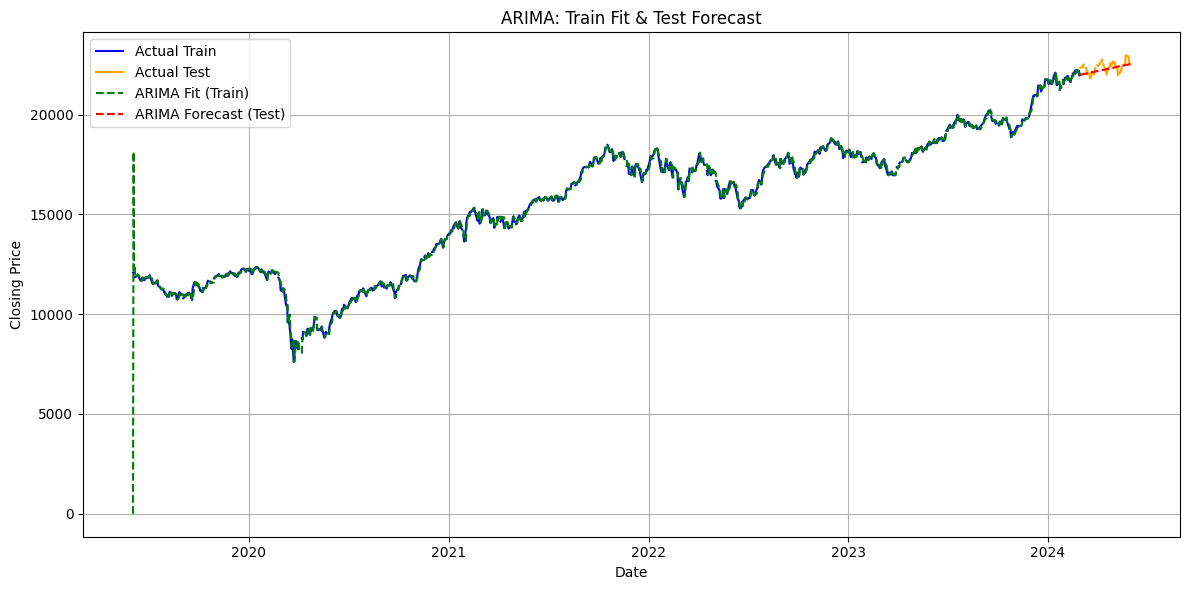

In [8]:
plt.figure(figsize=(12, 6))

# Plot actual train and test
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')

# Plot fitted values on train
plt.plot(arima_fitted_values, label="ARIMA Fit (Train)", color='green', linestyle='--')

# Plot forecast on test
plt.plot(arima_forecast, label="ARIMA Forecast (Test)", color='red', linestyle='--')

# Title and legends
plt.title("ARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np


# Drop NaNs and align
arima_fitted_values_clean = arima_fitted_values.dropna()
train_aligned = train.loc[arima_fitted_values_clean.index].dropna()

# Ensure same index
common_index = arima_fitted_values_clean.index.intersection(train_aligned.index)

# Final aligned series
fitted_final = arima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Equal length
min_len = min(len(fitted_final), len(train_final))
fitted_final = fitted_final[-min_len:]
train_final = train_final[-min_len:]

# Test RMSE for ARIMA

# Drop NaNs and align
arima_forecast_clean = arima_forecast.dropna()
test_clean = test.loc[arima_forecast_clean.index].dropna()

min_len_test = min(len(arima_forecast_clean), len(test_clean))
arima_forecast_final = arima_forecast_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]

# Test RMSE
test_rmse_arima = np.sqrt(mean_squared_error(test_final, arima_forecast_final))
arima_mape = mean_absolute_percentage_error(test_final, arima_forecast_final)

print(f"ARIMA Test RMSE: {test_rmse_arima:.3f}")
print(f"ARIMA Test MAPE: {arima_mape:.3f}")

ARIMA Test RMSE: 255.884
ARIMA Test MAPE: 0.010


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# Defining p, d, q range
P = D = Q = range(0, 4)
s = 5  # For weekly seasonality in stock data (Mon–Fri)

PDQ = list(itertools.product(P, D, Q))
seasonal_PDQs = [(p, d, q, s) for (p, d, q) in PDQ]

best_seasonal_aic = np.inf
best_seasonal_order = None

print("Trying combinations:")
for seasonal_order in seasonal_PDQs:
    try:
        sarima_model = SARIMAX(train,
                        order=best_order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        sarima_model_fit = sarima_model.fit()
        print(f"SARIMA{seasonal_order} AIC: {sarima_model_fit.aic}")
        if sarima_model_fit.aic < best_seasonal_aic:
            best_seasonal_aic = sarima_model_fit.aic
            best_seasonal_order = seasonal_order
    except:
        continue

print("\nBest ARIMA order:", best_seasonal_order)

# Fit SARIMA model on training data
sarima_model = SARIMAX(train,
                       order=best_order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()
print(sarima_result.summary())
# best order is 3 1 1 5

Trying combinations:
SARIMA(0, 0, 0, 5) AIC: 15161.724615338402
SARIMA(0, 0, 1, 5) AIC: 15097.846877299533
SARIMA(0, 0, 2, 5) AIC: 15032.417810112558
SARIMA(0, 0, 3, 5) AIC: 14996.973884952644
SARIMA(0, 1, 0, 5) AIC: 15731.420891232314
SARIMA(0, 1, 1, 5) AIC: 15257.198076594923
SARIMA(0, 1, 2, 5) AIC: 14998.063561837931
SARIMA(0, 1, 3, 5) AIC: 14973.991907909534
SARIMA(0, 2, 0, 5) AIC: 16623.3011495274
SARIMA(0, 2, 1, 5) AIC: 16307.27965100549
SARIMA(0, 2, 2, 5) AIC: 16144.543599952282
SARIMA(0, 2, 3, 5) AIC: 16072.750299013347
SARIMA(0, 3, 0, 5) AIC: 17588.355940357877
SARIMA(0, 3, 1, 5) AIC: 17076.29664547799
SARIMA(0, 3, 2, 5) AIC: 17910.728376032734
SARIMA(0, 3, 3, 5) AIC: 17838.626820840687
SARIMA(1, 0, 0, 5) AIC: 15121.52072107323
SARIMA(1, 0, 1, 5) AIC: 15123.08323313874
SARIMA(1, 0, 2, 5) AIC: 15043.179797734792
SARIMA(1, 0, 3, 5) AIC: 14998.613229666033
SARIMA(1, 1, 0, 5) AIC: 15624.704680446743
SARIMA(1, 1, 1, 5) AIC: 15170.950304337412
SARIMA(1, 1, 2, 5) AIC: 15302.726783432

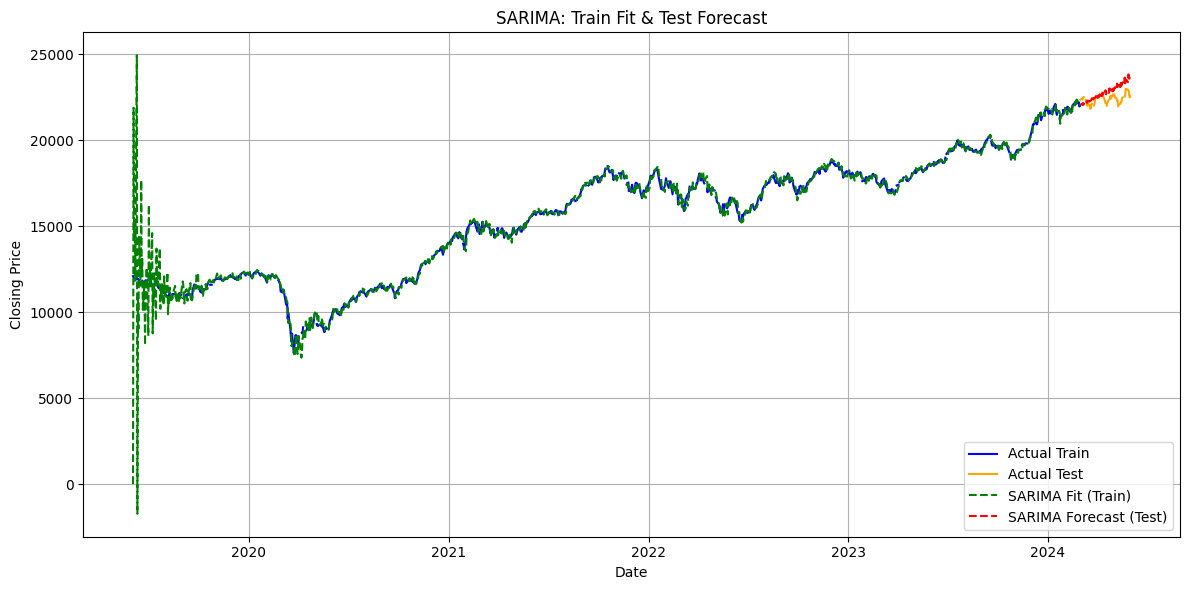

In [14]:
# Fitted values on train
sarima_fitted_values = sarima_result.fittedvalues

# Forecast on test
forecast_sarima = sarima_result.forecast(steps=len(test))
forecast_sarima.index = test.index  # Align with test set

# Plot everything
plt.figure(figsize=(12, 6))
plt.plot(train, label="Actual Train", color='blue')
plt.plot(test, label="Actual Test", color='orange')
plt.plot(sarima_fitted_values, label="SARIMA Fit (Train)", color='green', linestyle='--')
plt.plot(forecast_sarima, label="SARIMA Forecast (Test)", color='red', linestyle='--')

plt.title("SARIMA: Train Fit & Test Forecast")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Drop NaNs from both fitted and actual train data
sarima_fitted_values_clean = sarima_fitted_values.dropna()
train_aligned = train.loc[sarima_fitted_values_clean.index].dropna()

# Ensure matching index
common_index = sarima_fitted_values_clean.index.intersection(train_aligned.index)

# Filter both to matching dates only and drop NaNs again (final cleanup)
fitted_final = sarima_fitted_values_clean.loc[common_index].dropna()
train_final = train_aligned.loc[common_index].dropna()

# Final safeguard: ensure same length
min_len = min(len(train_final), len(fitted_final))
train_final = train_final[-min_len:]
fitted_final = fitted_final[-min_len:]

# Test RMSE for SARIMA
forecast_sarima_clean = forecast_sarima.dropna()
test_clean = test.loc[forecast_sarima_clean.index].dropna()

# Align lengths
min_len_test = min(len(forecast_sarima_clean), len(test_clean))
forecast_sarima_final = forecast_sarima_clean[-min_len_test:]
test_final = test_clean[-min_len_test:]


rmse = np.sqrt(mean_squared_error(test_final, forecast_sarima_final))
mape = mean_absolute_percentage_error(test_final, forecast_sarima_final)

print(f"RMSE: {rmse:.3f}")
print(f"MAPE: {mape:.3f}%")



RMSE: 626.001
MAPE: 0.023%
